# Validação do Modelo Identificado

In [1]:
import matplotlib.pyplot as plt

import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import control as ct
import scipy
import scipy.signal as sg
from control.matlab import *
from sklearn.metrics import mean_squared_error
import scienceplots

#!pip install scienceplots

%config InlineBackend.figure_format='retina'
plt.style.use(["science", "notebook"])


SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)

## Parâmetros de Ensaio

>> Offset = 1V\
>> Frequência do sinal de referência: 0.2 Hz\
>> Amplitude do sinal: 10°\
>> Periodo de amostragem do sinal: 0.02

In [2]:
# (url github) https://github.com/Oseiasdfarias/Projeto_Tcc_Oseias_Oficial/blob/main/interface_aeropendulo/interface/dados_de_ensaio/arquivo_25_6_2023_16_20_28.csv
file = "../../../interface_aeropendulo/src_interface/dados_de_ensaio/arquivo_13_9_2023_23_48_56.csv"
dados_malha_aberta = pd.read_csv(file, header=None, sep=',').values
dados_malha_aberta[0][0] = 0.0
dados_malha_aberta

array([[0.00000e+00, 0.00000e+00, 1.00000e+00, ..., 4.00000e+00,
        5.00000e+00, 6.00000e+00],
       [0.00000e+00, 4.09900e+01, 3.16480e+01, ..., 1.00000e+00,
        1.00000e+00, 2.65200e+01],
       [1.00000e+00, 4.09900e+01, 3.16480e+01, ..., 1.00000e+00,
        1.00000e+00, 2.65400e+01],
       ...,
       [5.48200e+03, 3.10000e+01, 3.19780e+01, ..., 1.00000e+00,
        1.00000e+00, 1.36152e+02],
       [5.48300e+03, 3.10000e+01, 3.19780e+01, ..., 1.00000e+00,
        1.00000e+00, 1.36172e+02],
       [5.48400e+03, 3.10000e+01, 3.20440e+01, ..., 1.00000e+00,
        1.00000e+00, 1.36192e+02]])

In [3]:
tempo = np.array(dados_malha_aberta[:,7])
sinal_entrada  = np.array(dados_malha_aberta[:,1])
sinal_saida = np.array(dados_malha_aberta[:,2])

# Convertendo o sinal de Graus para Radianos
sinal_saida = np.squeeze(np.deg2rad(sinal_saida[50:]))
sinal_entrada = np.squeeze(np.deg2rad(sinal_entrada[50:]))
tempo = tempo[50:] - min(tempo[50:])

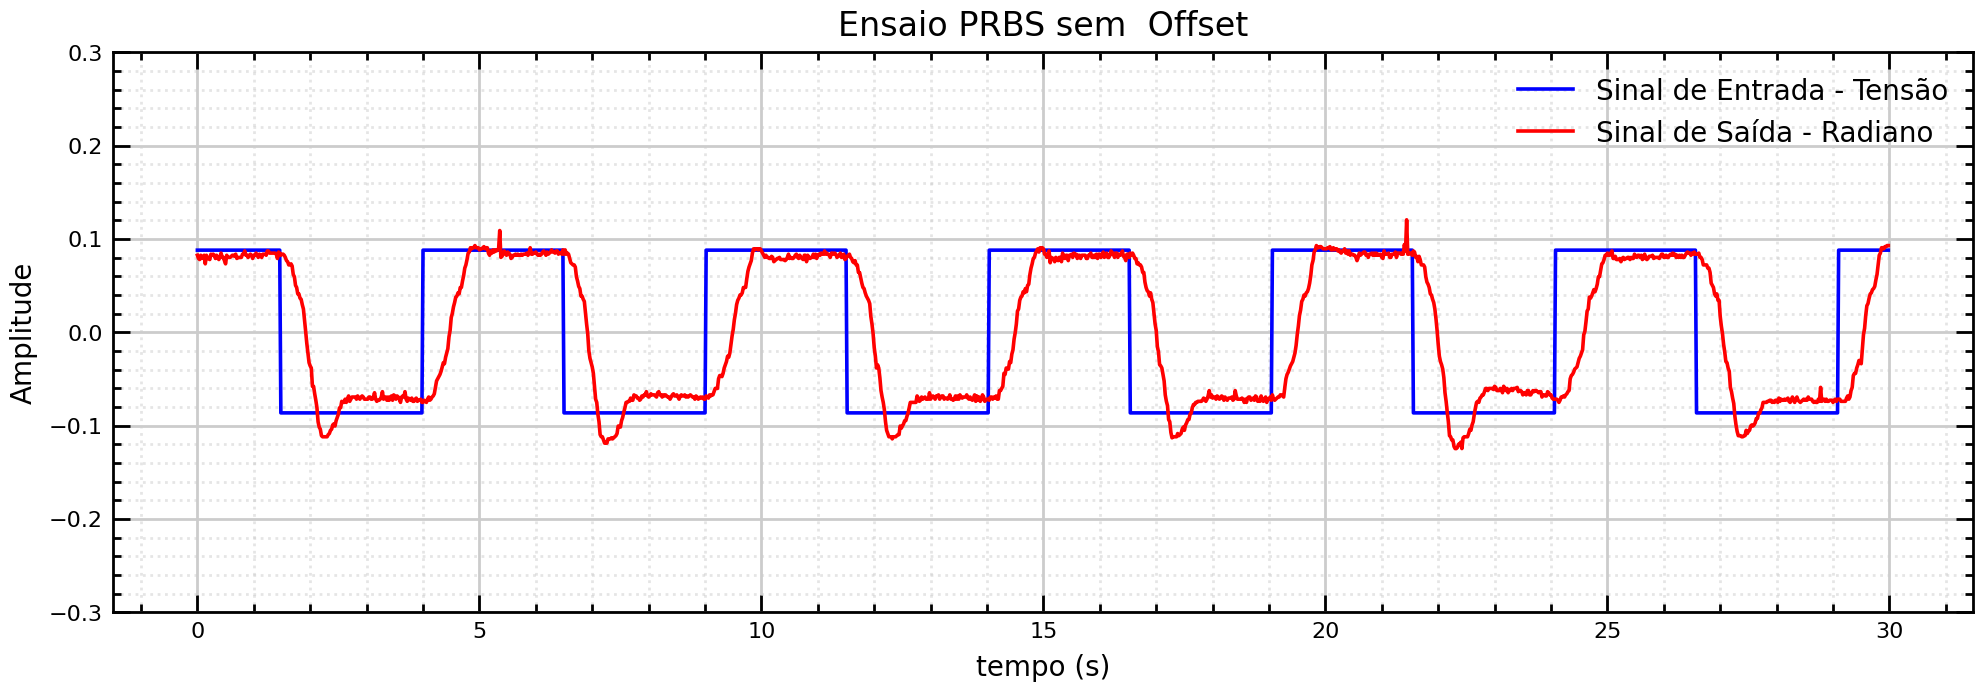

In [4]:
plt.figure(figsize=(12, 8))
plt.subplot(211)

intend = 1500

plt.plot(tempo[:intend], sinal_entrada[:intend] - np.mean(sinal_entrada[:intend]),
         c = 'b', lw=1.3, label = "Sinal de Entrada - Tensão")
plt.plot(tempo[:intend], (sinal_saida[:intend]) - np.mean((sinal_saida[:intend])),
         c = 'r', lw=1.3, label = "Sinal de Saída - Radiano")

plt. title('Ensaio PRBS sem  Offset', fontsize=12)
plt.ylabel('Amplitude', fontsize=10)
plt.xlabel('tempo (s)', fontsize=10)
plt.legend(fontsize=10)
plt.yticks(np.arange(-0.3, 0.4, 0.1))

plt.grid(which='both')
plt.grid(which='major', color='#CCCCCC', linestyle='-', alpha=1)
plt.grid(which='minor', color='#CCCCCC', linestyle=':', alpha=0.5)

plt.show()

## Modelo

Modelo Discreto

$$\frac{-0.002414 z + 0.01115}{z^5 - 0.9485 z^4 - 0.3122 z^3 - 0.007337 z^2 + 0.1263 z + 0.1573}\quad dt = 0.02$$

In [5]:
num_z = np.array([-0.002414, 0.01115])
den_z = np.array([1, -0.9485, -0.3122, -0.007337, 0.1263, 0.1573])
Gz = ct.tf(num_z, den_z, 0.02)
Gz

TransferFunction(array([-0.002414,  0.01115 ]), array([ 1.      , -0.9485  , -0.3122  , -0.007337,  0.1263  ,  0.1573  ]), 0.02)

Proximação de um Modelo Continuo a partir do modelo discreto

$$\displaystyle \frac{0.008736}{0.0009883437 s^{2} + 0.00668674000000001 s + 0.015563}$$

In [6]:
num_c = np.array([0.008736])
den_c = np.array([0.0009883437, 0.00668674000000001, 0.015563])
Gs = ct.tf(num_c, den_c)
Gs

TransferFunction(array([0.008736]), array([0.00098834, 0.00668674, 0.015563  ]))

## Controle PID